In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [2]:
dataloc = "http://gliders.ioos.us/thredds/dodsC/deployments/rutgers/ng619-20200722T1900/ng619-20200722T1900.nc3.nc?trajectory[0:1:0],wmo_id[0:1:0],time[0:1:0][0:1:8604],latitude[0:1:0][0:1:8604],longitude[0:1:0][0:1:8604],time_uv[0:1:0][0:1:8604],lat_uv[0:1:0][0:1:8604],lon_uv[0:1:0][0:1:8604],precise_time[0:1:0][0:1:8604][0:1:268],depth[0:1:0][0:1:8604][0:1:268],pressure[0:1:0][0:1:8604][0:1:268],temperature[0:1:0][0:1:8604][0:1:268],conductivity[0:1:0][0:1:8604][0:1:268],salinity[0:1:0][0:1:8604][0:1:268],density[0:1:0][0:1:8604][0:1:268]"
df      = xr.open_dataset(dataloc, decode_times=False)

In [7]:
dataAS  = "../data/AtlanticShores_833d_ebdb_69d0_d81b_55e4_f5f5.nc"
dAS     = xr.open_dataset(dataAS)

In [8]:
dAS

<xarray.Dataset>
Dimensions:                                                  (row: 202504)
Dimensions without coordinates: row
Data variables:
    time                                                     (row) datetime64[ns] ...
    station_name                                             (row) object ...
    latitude                                                 (row) float64 ...
    longitude                                                (row) float64 ...
    depth                                                    (row) float64 ...
    sea_water_velocity_to_direction                          (row) float64 ...
    sea_water_speed                                          (row) float64 ...
    sea_water_velocity_to_direction_qartod_gross_range_test  (row) int8 ...
    sea_water_velocity_to_direction_qartod_flat_line_test    (row) int8 ...
    sea_water_velocity_to_direction_qartod_aggregate         (row) int8 ...
    sea_water_speed_qartod_gross_range_test                  (row) int8 ...
    sea_water_speed_qartod_flat_line_test                    (row) int8 ...
    sea_water_speed_qartod_aggregate                         (row) int8 ...
Attributes:
    cdm_data_type:                   TimeSeriesProfile
    cdm_profile_variables:           time
    cdm_timeseries_variables:        station_name, latitude, longitude
    Conventions:                     CF-1.7, ACDD-1.3, COARDS
    creator_country:                 USA
    creator_name:                    Fugro
    creator_url:                     https://www.fugro.com/about-fugro/our-ex...
    date_created:                    2020-09-18T11:45:09Z
    date_issued:                     2020-09-18T11:45:09Z
    date_metadata_modified:          2020-09-18T11:45:09Z
    date_modified:                   2020-09-18T11:45:09Z
    Easternmost_Easting:             -73.8892
    featureType:                     TimeSeriesProfile
    geospatial_bounds:               POINT(39.2717 -73.8892)
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:4297
    geospatial_lat_max:              39.2717
    geospatial_lat_min:              39.2717
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              -73.8892
    geospatial_lon_min:              -73.8892
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         36.0
    geospatial_vertical_min:         3.0
    geospatial_vertical_positive:    down
    geospatial_vertical_units:       m
    history:                         Created by the RPS harvester from data a...
    id:                              AtlanticShores
    infoUrl:                         https://www.atlanticshoreswind.com/
    institution:                     Atlantic Shores Offshore Wind
    keywords:                        'Oceans > Ocean Circulation > Ocean Curr...
    keywords_vocabulary:             GCMD Science Keywords
    license:                         The data may be used and redistributed f...
    metadata_link:                   https://www.atlanticshoreswind.com
    naming_authority:                com.atlanticshoreswind
    nodc_template_version:           NODC_TimeSeriesProfile_Template_v2.0
    Northernmost_Northing:           39.2717
    platform:                        station_name
    platform_name:                   Atlantic Shores
    platform_vocabulary:             http://mmisw.org/ont/ioos/platform
    processing_level:                raw
    project:                         Atlantic Shores Offshore Wind
    publisher_country:               USA
    publisher_email:                 devops@rpsgroup.com
    publisher_institution:           MARACOOS
    publisher_name:                  MARACOOS
    publisher_phone:                 (401) 789-6224
    publisher_type:                  institution
    publisher_url:                   https://www.maracoos.org
    source:                          Atlantic Shores Offshore Wind
    sourceUrl:                       (local files)


In [12]:
dAS

<xarray.Dataset>
Dimensions:                                                  (row: 202504)
Dimensions without coordinates: row
Data variables:
    time                                                     (row) datetime64[ns] ...
    station_name                                             (row) object ...
    latitude                                                 (row) float64 ...
    longitude                                                (row) float64 ...
    depth                                                    (row) float64 ...
    sea_water_velocity_to_direction                          (row) float64 ...
    sea_water_speed                                          (row) float64 ...
    sea_water_velocity_to_direction_qartod_gross_range_test  (row) int8 ...
    sea_water_velocity_to_direction_qartod_flat_line_test    (row) int8 ...
    sea_water_velocity_to_direction_qartod_aggregate         (row) int8 ...
    sea_water_speed_qartod_gross_range_test                  (row) int8 ...
    sea_water_speed_qartod_flat_line_test                    (row) int8 ...
    sea_water_speed_qartod_aggregate                         (row) int8 ...
Attributes:
    cdm_data_type:                   TimeSeriesProfile
    cdm_profile_variables:           time
    cdm_timeseries_variables:        station_name, latitude, longitude
    Conventions:                     CF-1.7, ACDD-1.3, COARDS
    creator_country:                 USA
    creator_name:                    Fugro
    creator_url:                     https://www.fugro.com/about-fugro/our-ex...
    date_created:                    2020-09-18T11:45:09Z
    date_issued:                     2020-09-18T11:45:09Z
    date_metadata_modified:          2020-09-18T11:45:09Z
    date_modified:                   2020-09-18T11:45:09Z
    Easternmost_Easting:             -73.8892
    featureType:                     TimeSeriesProfile
    geospatial_bounds:               POINT(39.2717 -73.8892)
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:4297
    geospatial_lat_max:              39.2717
    geospatial_lat_min:              39.2717
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              -73.8892
    geospatial_lon_min:              -73.8892
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         36.0
    geospatial_vertical_min:         3.0
    geospatial_vertical_positive:    down
    geospatial_vertical_units:       m
    history:                         Created by the RPS harvester from data a...
    id:                              AtlanticShores
    infoUrl:                         https://www.atlanticshoreswind.com/
    institution:                     Atlantic Shores Offshore Wind
    keywords:                        'Oceans > Ocean Circulation > Ocean Curr...
    keywords_vocabulary:             GCMD Science Keywords
    license:                         The data may be used and redistributed f...
    metadata_link:                   https://www.atlanticshoreswind.com
    naming_authority:                com.atlanticshoreswind
    nodc_template_version:           NODC_TimeSeriesProfile_Template_v2.0
    Northernmost_Northing:           39.2717
    platform:                        station_name
    platform_name:                   Atlantic Shores
    platform_vocabulary:             http://mmisw.org/ont/ioos/platform
    processing_level:                raw
    project:                         Atlantic Shores Offshore Wind
    publisher_country:               USA
    publisher_email:                 devops@rpsgroup.com
    publisher_institution:           MARACOOS
    publisher_name:                  MARACOOS
    publisher_phone:                 (401) 789-6224
    publisher_type:                  institution
    publisher_url:                   https://www.maracoos.org
    source:                          Atlantic Shores Offshore Wind
    sourceUrl:                       (local files)


In [23]:
start = mdates.date2num(datetime.datetime(2020,8,4,0))
enddd = mdates.date2num(datetime.datetime(2020,8,5,18))
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')

In [27]:
vellen = len(dAS.sea_water_speed[::34].values)

cross_shelf_u = np.ones((34,vellen))
u_angle       = np.ones((34,vellen))
along_shelf_v = np.ones((34,vellen))
coast_angle   = 0

for i in range(34):
    cross_shelf_u[i,:] = dAS.sea_water_speed[i::34].values*np.cos(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle))
    u_angle[i,:]       = np.mod(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle),2*np.pi)
    along_shelf_v[i,:] = dAS.sea_water_speed[i::34].values*np.sin(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle))
    
depths = -1*(np.arange(34)+3)
times  = mdates.date2num(dAS.time[::34])

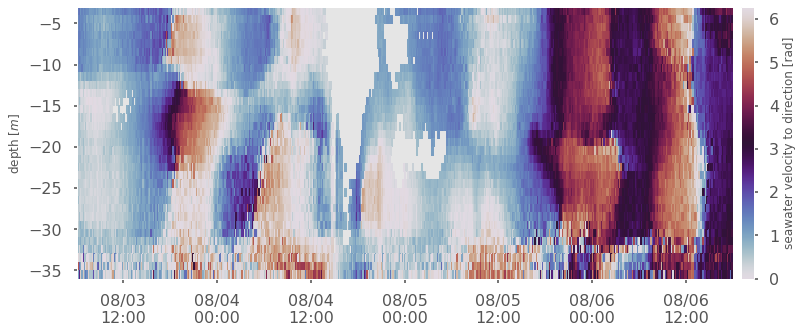

In [51]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, u_angle, vmin=0, vmax=2*np.pi, cmap='twilight')
plt.colorbar(pad=0.01, label="seawater velocity to direction [rad]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_theta.png', bbox_inches='tight', dpi=200)
plt.show()

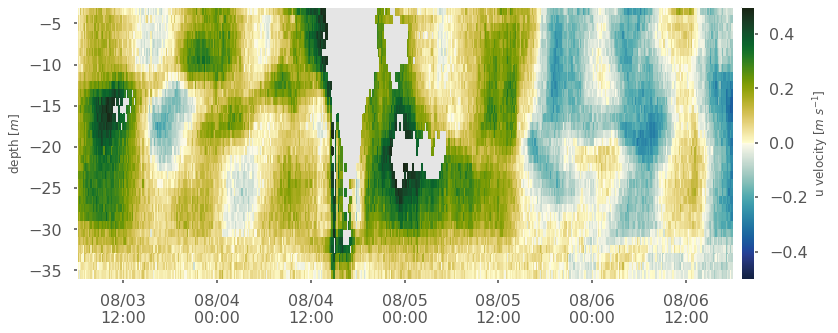

In [48]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, cross_shelf_u/100, vmax=0.5, vmin=-0.5, cmap='cmo.delta')
plt.colorbar(pad=0.01, label="u velocity [$m$ $s^{-1}$]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
#plt.savefig('Isaias_AtlanticShores_u.png', bbox_inches='tight', dpi=200)
plt.show()

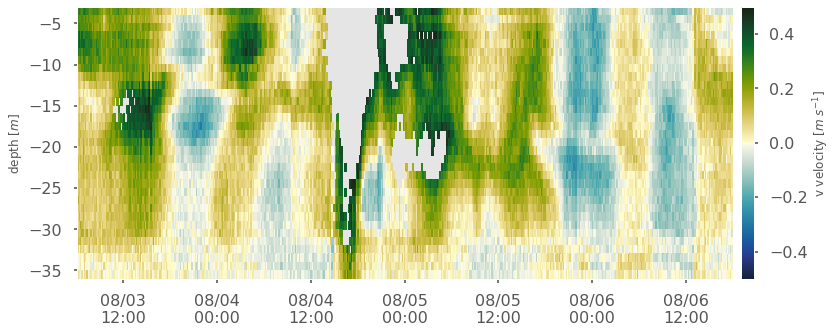

In [46]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, along_shelf_v/100, vmax=0.5, vmin=-0.5, cmap='cmo.delta')
plt.colorbar(pad=0.01, label="v velocity [$m$ $s^{-1}$]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_v.png', bbox_inches='tight', dpi=200)
plt.show()

In [79]:
dudz = np.gradient(cross_shelf_u,axis=0)/100
dvdz = np.gradient(along_shelf_v,axis=0)/100
S2   = dudz**2 + dvdz**2

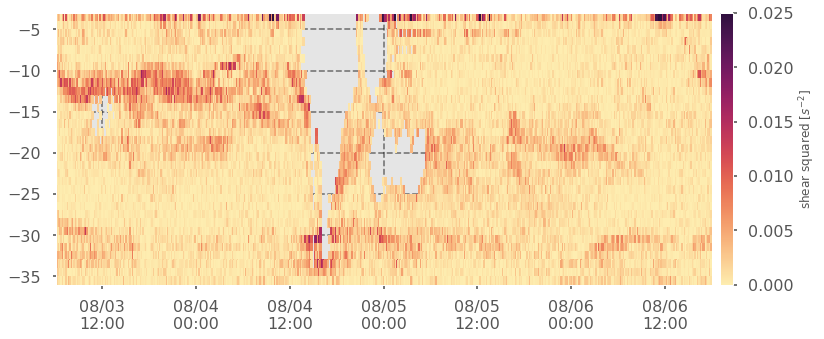

In [81]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, S2, vmax=0.025, vmin=0, cmap='cmo.matter')
plt.colorbar(pad=0.01, label="shear squared [$s^{-2}$]")
plt.xlim([start-1, enddd+1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid(c='k', linestyle='--', alpha=0.5)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_S2.png', bbox_inches='tight', dpi=200)
plt.show()

In [38]:
time_origin = datetime.datetime(1970,1,1)
datenum = np.ones_like(df.depth.values)
dlen    = np.shape(df.depth)[2]
for i, sec in enumerate(df.time.values[0,:]):
    datetmp   = time_origin + datetime.timedelta(seconds = sec)
    datenum[0,i,:] = mdates.date2num(datetmp)*np.ones(dlen)

In [52]:
dP = np.gradient(df.depth[0,:,:].values, axis=(1))
dt = np.gradient(datenum, axis=(1)) / 96400
dPdt = dP/dt

<ipython-input-52-8776d4ee8648>:3: RuntimeWarning: divide by zero encountered in true_divide
  dPdt = dP/dt
<ipython-input-52-8776d4ee8648>:3: RuntimeWarning: invalid value encountered in true_divide
  dPdt = dP/dt


In [53]:
### binning
x = datenum[0,:,:].reshape(np.size(datenum[0,:,:]))
y = -df.depth[0,:,:].values.reshape(np.size(datenum[0,:,:]))
t = df.temperature[0,:,:].values.reshape(np.size(datenum[0,:,:]))
timepoints = int((enddd - start)*24)+1 #
tgrid = np.linspace(start,enddd,timepoints)
zgrid = np.linspace(-95,-5,91)
T, Z = np.meshgrid(tgrid,zgrid)

In [54]:
TEMPS = np.ones_like(T)
np.shape(TEMPS)

(91, 37)

In [55]:
for i in range(len(tgrid)-1):
    Tmore = x > tgrid[i]
    Tless = x < tgrid[i+1]
    qT = np.logical_and(Tmore,Tless)
    for j in range(len(zgrid)-1):
        Zmore = y > zgrid[j]
        Zless = y < zgrid[j+1]
        qZ = np.logical_and(Zmore,Zless)
        qALL = np.logical_and(qZ,qT)
        xZ = x[qALL]
        yZ = y[qALL]
        tZ = t[qALL]
        if len(tZ) > 0:
            TEMPS[j,i] = np.nanmedian(tZ)
        else:
            TEMPS[j,i] = np.nan

<ipython-input-55-a61ce867c68d>:6: RuntimeWarning: invalid value encountered in greater
  Zmore = y > zgrid[j]
<ipython-input-55-a61ce867c68d>:7: RuntimeWarning: invalid value encountered in less
  Zless = y < zgrid[j+1]


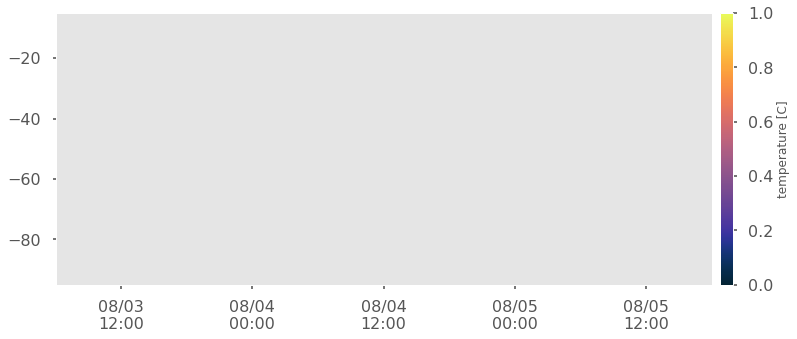

In [56]:
plt.figure(figsize=(14,5))
plt.pcolor(T, Z, TEMPS, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.xlim([start-1, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)

#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.savefig('Isaias_2020_wind.pdf', bbox_inches='tight')
plt.show()

In [57]:
winddata = "../data/44065h2020_current.txt"

In [58]:
ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)

In [59]:
list(ndb)

['#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR',
 'WSPD',
 'GST',
 'WVHT',
 'DPD',
 'APD',
 'MWD',
 'PRES',
 'ATMP',
 'WTMP',
 'DEWP',
 'VIS',
 'PTDY',
 'TIDE']

In [60]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
#ndb['datenum'] = ndb_datenum

In [61]:
ndb_datenum = np.asarray(ndb_datenum)

In [62]:
windspeed = np.ones_like(ndb['WSPD'][:])
winddir   = np.ones_like(ndb['WSPD'][:])

for i, wspd in enumerate(ndb['WSPD'][:]):
    try:
        windspeed[i] = np.float(wspd)
        winddir[i]   = np.float(ndb['WDIR'][i])
    except:
        windspeed[i] = 0
        winddir[i]   = 0
    

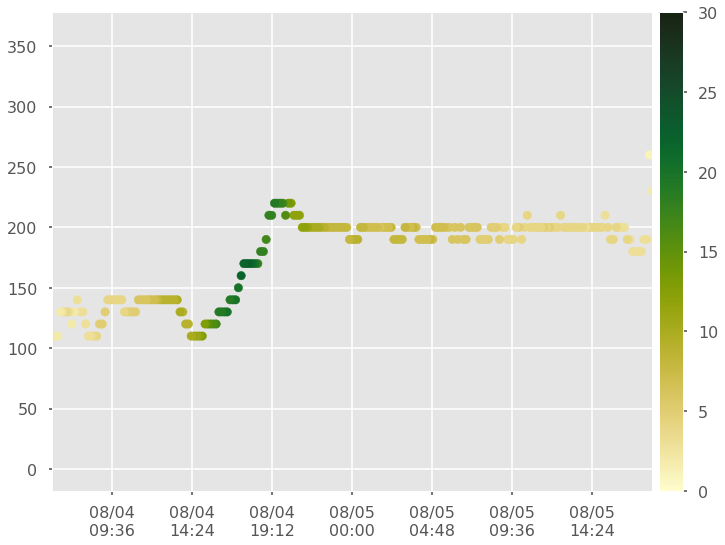

In [63]:
plt.scatter(ndb_datenum, winddir, c=windspeed, cmap=cmo.speed, s=70, vmin=0, vmax=30)
plt.colorbar(pad=0.01)
#plt.ylim([0, 25])
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)

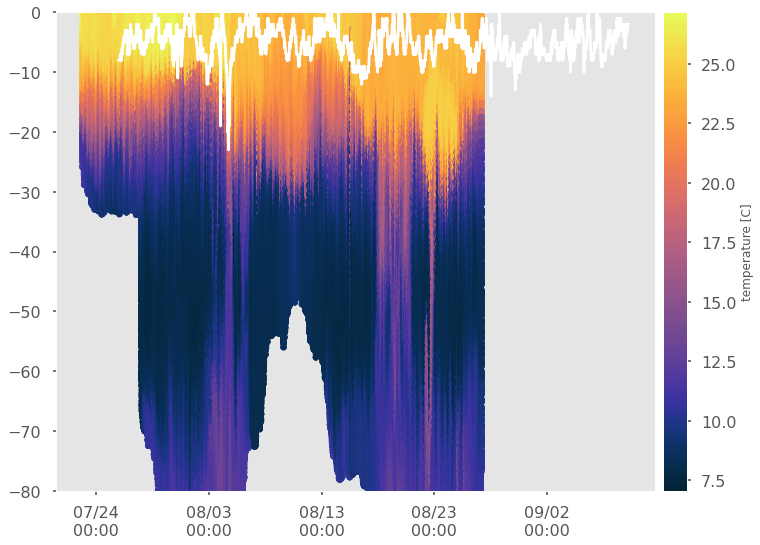

In [78]:
plt.scatter(datenum[0,:,:], -df.depth[0,:,:], c=df.temperature[0,:,:], s=36, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.plot(ndb_datenum, -1*(windspeed), c='w')
#plt.xlim([mdates.date2num(datetime.datetime(2020,8,4,12)), mdates.date2num(datetime.datetime(2020,8,4,18))])
plt.ylim([-80,0])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()

In [65]:
depthlines = np.arange(50)+5
casttimes = datenum[0,:,0]
np.shape(casttimes)

DLINES, CTIMES = np.meshgrid(depthlines, casttimes)

In [66]:
np.shape(DLINES)

(8605, 50)

In [67]:
TLINES = np.ones_like(DLINES) * np.nan

for i, tnum in enumerate(casttimes[:]):
    d = df.depth[0,i,:].values
    temps = df.temperature[0,i,:].values
    maxD = np.nanmax(d)
    tgood = temps[np.isfinite(temps)]
    dgood = d[np.isfinite(temps)]
    sortq = np.argsort(dgood)
    tgood = tgood[sortq]
    dgood = dgood[sortq]
    q = np.where(depthlines < maxD)
    xx = depthlines[q]
    TLINES[i,:len(xx)] = np.interp(xx,dgood,tgood)
    #plt.plot(xx, np.interp(xx,dgood,tgood))

In [68]:
import scipy.interpolate as interp

def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    new_d = np.arange(mindepth,maxdepth,0.1)
    y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
    new_tmp = y(new_d)
    tmp_low = np.abs(new_tmp - low)
    tmp_high = np.abs(new_tmp - high)
    q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
    q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
    #delta_d = new_d[q_high] - new_d[q_low]
    return new_d[q_high], new_d[q_low]

np.shape(TLINES)

(8605, 50)

In [69]:
low_depth  = np.ones_like(casttimes)
high_depth = np.ones_like(casttimes)

for I in range(len(casttimes)):
    new_tmp = TLINES[I,:]
    if sum(np.isfinite(new_tmp)) > 3:
        tmp_low = np.abs(new_tmp - 14)
        tmp_high = np.abs(new_tmp - 20)
        q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
        q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
        a, b = depthlines[q_high], depthlines[q_low]
        if np.abs(a-b) < 0.25:
            low_depth[I], high_depth[I] = np.nan, np.nan
        else:
            low_depth[I], high_depth[I] = a, b
    else: low_depth[I], high_depth[I] = np.nan, np.nan

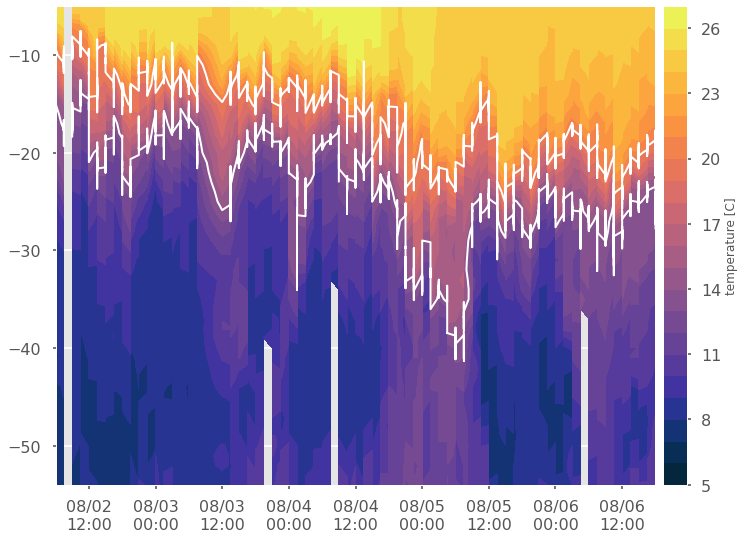

In [77]:
plt.contourf(CTIMES, -DLINES, TLINES, cmap='cmo.thermal', levels=np.arange(23)+5)
plt.xlim([start-2, enddd+1])
plt.colorbar(pad=0.01, label="temperature [C]")
plt.contour(CTIMES, -DLINES, TLINES, levels=np.array([14,20]), colors='w', linewidths=2)
#plt.plot(ndb_datenum, 1*(windspeed), c='r')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.savefig('Isaias_2020_wind.pdf', bbox_inches='tight')

Text(0, 0.5, 'pycnocline width [m]')

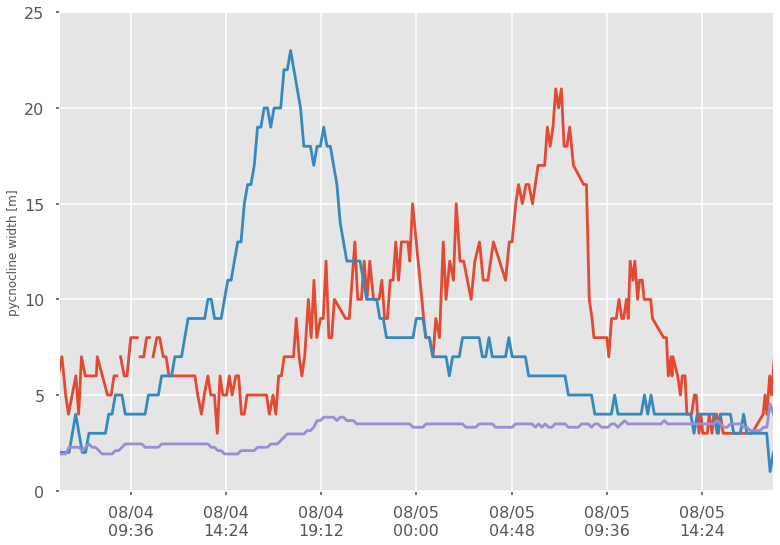

In [29]:
plt.plot(casttimes, high_depth - low_depth)
plt.plot(ndb_datenum, (windspeed))
plt.plot(ndb_datenum, (winddir)*np.pi/180)
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([0,25])
plt.ylabel('pycnocline width [m]')